In [1]:
import pandas as pd
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.linear_model import RidgeCV, LinearRegression, LassoCV
import numpy as np
from sklearn.preprocessing import scale, normalize
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import  PolynomialFeatures , FunctionTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.preprocessing import SplineTransformer
from sklearn.model_selection import LeavePOut
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import QuantileTransformer




loading the data by using numpy, as the data is in csv file we use ',' as delimeter and we skip the first row which is the header

In [2]:
data = np.loadtxt('PADL-Q2-train.csv',delimiter=',',skiprows=1)



a number of basis functions was considered that are got by creating new variables from existing features that we have, these new variables are non linear functions to the original ones.  polynomial regression is tried to try to fit the data to a polynomial of different degrees that we used (2,3). as we have only 80 datapoints, degrees more than 3 was not used as it will lead to so much overfitting where the model memorizes and not learn, also as only linear regression is used without regularization so using degree more than 3 will make it prone to overfitting, sin and cos functions was tried as basis functions to try to capture the non linear patterns and oscillations as when plotting the features and target values, the data shows alot of up and down patterns. exp was tried as a basis function to model exponential inclines or declines in the data. Because the different features in the training data have alot of ranges, log1p is used to compress these values and to capture non linear relationships. Data scaling and normalization was experimented with by having 5 versions of training data, a normal one with no scaling or normalization, a one by using standard scaling that removes the mean and scale to the unit varience. Min Max scaling was tried that scale the feature to a range from 0 to 1, and normalizing the data to having a unit norm was tried. When looking at the values of the features in the dataset, Scaling and normalization can be seen as a good idea because of the different ranges and scales every feature have, without scaling and normalization, some features can have dominance on other features. Using normalization and scaling restrain this. All of the models are evaluated using cross validation because of the small number of datapoints, so to ensure that the models are tested and trained on everything, cross validation is used instead of the regular training and testing split.

we evaluate all the models by first having a loop pver the basis functions selected, then we have an inner loop for the different scaling and normalizing techniques that is chosen. Then make_pipeline is used to pipeline the basis function of the current index in the outer loop and the dataset of the index of the inner loop with a linear regression model. Then the different folds of the data done by using the K-fold corss validation technique is looped over and trained on the training part of this split and then evaluated on the testing part. the error metric used is r2

In [3]:
X = data[:, :-1]
y = data[:, -1]

normalize_transformer = FunctionTransformer(normalize, validate=True)



minmax_scale_pipeline = make_pipeline(MinMaxScaler(), StandardScaler())
minmax_normalize_pipeline = make_pipeline(MinMaxScaler(), normalize_transformer)
scale_normalize_pipeline = make_pipeline(StandardScaler(), normalize_transformer)

datasets = [
    ('regular', None),  # No scaling
    ('min_max', MinMaxScaler()),  # Min-Max Scaling
    ('standard', StandardScaler()),  # Standard Scaling
    ('normalize', normalize_transformer),  # Normalization
    ('minmax_scale', minmax_scale_pipeline),  # Min-Max Scaling followed by Standard Scaling
    ('minmax_normalize', minmax_normalize_pipeline),  # Min-Max Scaling followed by Normalization
    ('standars_normalize', scale_normalize_pipeline)
    ]
datasets_names = ['Regular Dataset', 'Min Max Dataset', 'Standard Scaler', 'Normalize Dataset', 'MinMax and Scale Dataset', 'MinMax and Normalize Dataset', 'Standard Scaling with Normalize dataset']


basis_functions = [
    PolynomialFeatures(2, interaction_only=True, include_bias=False),
    PolynomialFeatures(3, interaction_only=True, include_bias=False),
    FunctionTransformer(np.sin, validate=True),
    FunctionTransformer(np.cos, validate=True),
    FunctionTransformer(np.exp, validate=True),
    FunctionTransformer(np.log1p, validate=True),
]

best_r2 = -9999
best_comb = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("Evaluating Linear Regression with different basis functions and scaling/normalization techniques\n")

for function in basis_functions:

    print("Using basis functions", function ,"\n\n")
    for j, (name, dataset) in enumerate(datasets):
        print(f"Using: {datasets_names[j]} with {function}")


        if dataset is None:
            pipeline = make_pipeline(function, LinearRegression())
        else:
            pipeline = make_pipeline(function, dataset, LinearRegression())

        scores = []

        for train, test in kf.split(X):
            X_train, X_test = X[train], X[test]
            y_train, y_test = y[train], y[test]

            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            scores.append(r2)

        mean_r2 = np.mean(scores)
        print(f"Mean R²: {mean_r2}\n")

Evaluating Linear Regression with different basis functions and scaling/normalization techniques

Using basis functions PolynomialFeatures(include_bias=False, interaction_only=True) 


Using: Regular Dataset with PolynomialFeatures(include_bias=False, interaction_only=True)
Mean R²: 0.10331581007811526

Using: Min Max Dataset with PolynomialFeatures(include_bias=False, interaction_only=True)
Mean R²: 0.10331581007810917

Using: Standard Scaler with PolynomialFeatures(include_bias=False, interaction_only=True)
Mean R²: 0.10331581007810772

Using: Normalize Dataset with PolynomialFeatures(include_bias=False, interaction_only=True)
Mean R²: -0.12300917381211492

Using: MinMax and Scale Dataset with PolynomialFeatures(include_bias=False, interaction_only=True)
Mean R²: 0.10331581007810811

Using: MinMax and Normalize Dataset with PolynomialFeatures(include_bias=False, interaction_only=True)
Mean R²: 0.1433456963304534

Using: Standard Scaling with Normalize dataset with PolynomialFeatures(

Linear Regression , Ridge Regression and Lasso Regression is all tried and evaluated on the same data. For Ridge and Lasso Regression, different regularization alphas was tried and the best one was picked using the built in cross validation. Piecewise regression is used to fit seperate linear models to different segments in the data because its hard to have only single functions that is able to predict all Y, so having more for every segment a model is appropiate as each model only models and predicts its segment, segments are divided using the breakpoints. Spline transformation was also tried by bolting different segments polynomial fits and connecting them in knots to fit non linear relationships. Cubic spline is the most common type of spline transformation as it is smooth enough and it balance between flexability and smoothness. the parameters of the piecewise regression was chosen based on the graph of the target value that shows a high rise in values of y after the data point number 70, thats why the breakpoint is set to 70, the slopes are based also on the trend before the breakpoint and after. The parameters had to be chosen this way and not optimised as there is unsufficient data to have a good optimized parameters as we have only 80 data point so its unable to estimate the parameters correctly. piecewise regression seperate the data into two segments according to the conditions, and then every segment is fitted to it a different model. the piecewise was built using numpy funcion piecewise that take the conditions specified and the functions to construct piecewise. the spline transformation transformation was done by using the function of SplineTransformer of skilearn. the number of knots was chosen to be 2 because we have only 80 datapoints so 2 is more than enough.

To train and evaluate all the models, all the models where looped over and initialized. then each model was tried in 3 versions, separtely, with piecewise, and with spline transformation. and each model was evaluated using cross validation K-fold technique.

In [4]:
def piecewise_linear(x):

    return np.piecewise(x, [x < 70, x >= 70], [lambda x: 0.9 *x + 0.8 - 0.9* 70, lambda x:-0.5 * x + 0.8 - (-0.5*70 )])

In [5]:
X = data[:, :-1]
y = data[:, -1]

myalphas = np.logspace(-5, 6, 13)

models = [LinearRegression, RidgeCV, LassoCV]
model_names = ['Linear Regression', 'Ridge Regression using CV', 'Lasso Regression using CV']


basis_functions = [
    None,
    SplineTransformer(degree=3, n_knots=2, include_bias=False),
    FunctionTransformer(piecewise_linear, validate=True)
]

best_r2 = -9999
best_comb = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for i, model in enumerate(models):
    print('\n\n Using Regression of type: ', model_names[i], "\n")

    if model == LinearRegression:
        reg = model()

    elif model == RidgeCV:
        print('Trying These Alpha values ', myalphas, "\n")
        reg = model(alphas=myalphas)

    else:
        print('Trying These Alpha values ', myalphas, "\n")
        reg = model(alphas=myalphas, max_iter=1000000)




    for function in basis_functions:

      if (function is None):
        pipeline = reg

      else:

        pipeline = make_pipeline(function, reg)

      scores = []

      for train, test in kf.split(X):
          X_train, X_test = X[train], X[test]
          y_train, y_test = y[train], y[test]

          pipeline.fit(X_train, y_train)
          y_pred = pipeline.predict(X_test)
          r2 = r2_score(y_test, y_pred)
          scores.append(r2)

      print(function)
      print(scores)
      print(np.mean(scores), "\n")

#       if np.mean(scores) > best_r2:
#           best_r2 = np.mean(scores)
#           best_comb = [model_names[i], function, np.mean(scores)]

# print("\n", "The best combination is: ", best_comb)




 Using Regression of type:  Linear Regression 

None
[-0.4802532598443363, 0.24215777831107954, 0.4053486530798138, 0.3252333270572627, 0.33431444096985863]
0.16536018791473567 

SplineTransformer(include_bias=False, n_knots=2)
[-0.2625754582266462, 0.3106901433591447, 0.448447734839571, 0.4016785122806167, 0.3570713664656]
0.2510624597436572 

FunctionTransformer(func=<function piecewise_linear at 0x7af863813880>,
                    validate=True)
[-0.3184603013171079, 0.2938553546676246, 0.38329754659927984, 0.28657448789894446, 0.3752670089567921]
0.20410681936110658 



 Using Regression of type:  Ridge Regression using CV 

Trying These Alpha values  [1.00000000e-05 8.25404185e-05 6.81292069e-04 5.62341325e-03
 4.64158883e-02 3.83118685e-01 3.16227766e+00 2.61015722e+01
 2.15443469e+02 1.77827941e+03 1.46779927e+04 1.21152766e+05
 1.00000000e+06] 

None
[-0.48650408001583645, 0.24364814657437417, 0.40883663836645023, 0.2957630022390425, 0.3471895436354342]
0.16178665015989294 


an automated procedure that trains all the models in the above 2 tasks and evaluate them were implemented, and at the end the model with best r2 is outputted. the models are trained and evaluated using cross validation with kfolds = 5, as we have unsufficient data to be able to do train and test split. the problem with cross validation is that it under estimates the model performance, outputting performance metrics worse than its actual performance, but it helps with overfitting as it trains and tests the models on different subsets of the data, so giving a reliable performance estimates. all the models implemented in the last 2 tasks were trained and tested on the same data to ensure a fair choosing procedure of the model. All different models such including Linear regression and models with regularization were built, Linear regression models were pipelined with basis functions and data scaling/ normalizing techniques, and also with piecewise regression and spline transformation, every version was trained and evaluated by cross validation. Models such as Ridge and Lasso regression were tried and also with piecewise, spline transformation, then trained and evaluated using Cross validation. every model's r2 value on the testing fold of the cross validation was recorded. at the end the model architecture that led to the best r2 value is outputted.

In [6]:
X = data[:, :-1]
y = data[:, -1]

myalphas = np.logspace(-5, 6, 13)


models = [LinearRegression, LinearRegression, RidgeCV, LassoCV]
model_names = ['Linear Regression task 1', 'Linear Regression task 2', 'Ridge Regression using CV', 'Lasso Regression using CV']


minMax = MinMaxScaler()
normaliser = Normalizer()
minMax_normaliser = make_pipeline(MinMaxScaler(), Normalizer())


datasets = [
    ('regular', None),  # No scaling
    ('min_max', MinMaxScaler()),  # Min-Max Scaling
    ('normalised', Normalizer()),  # Normalization
    ('min_max_normalised', minMax_normaliser)  # Min-Max Scaling followed by Normalization
]
datasets_names = ['Regular Dataset', 'Min Max Dataset', 'Normalised Dataset', 'Min Max Normal Dataset']


basis_functions_task1 = [
    PolynomialFeatures(2, interaction_only=True, include_bias=False),
    PolynomialFeatures(3, interaction_only=True, include_bias=False),
    FunctionTransformer(np.sin, validate=True),
    FunctionTransformer(np.cos, validate=True),
    FunctionTransformer(np.exp, validate=True),
    FunctionTransformer(np.log1p, validate=True),
]


basis_functions_task2 = [
    None,
    SplineTransformer(degree=3, n_knots=2, include_bias=False),
    FunctionTransformer(piecewise_linear, validate=True)
]

best_r2 = -9999
best_comb = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for i, model in enumerate(models):

    if model_names[i] == 'Linear Regression task 1':
        for function in basis_functions_task1:
            for j, (name, dataset) in enumerate(datasets):

                # Create pipeline
                if dataset is None:
                    pipeline = make_pipeline(function, LinearRegression())
                else:
                    pipeline = make_pipeline(function, dataset, LinearRegression())

                scores = []

                for train, test in kf.split(X):
                    X_train, X_test = X[train], X[test]
                    y_train, y_test = y[train], y[test]

                    pipeline.fit(X_train, y_train)
                    y_pred = pipeline.predict(X_test)
                    r2 = r2_score(y_test, y_pred)
                    scores.append(r2)

                mean_r2 = np.mean(scores)

                if mean_r2 > best_r2:
                    best_r2 = mean_r2
                    best_comb = [model_names[i], datasets_names[j], function]
    else:
        if model == LinearRegression:
            reg = model()
        elif model == RidgeCV:
            reg = model(alphas=myalphas)
        else:
            reg = model(alphas=myalphas, max_iter=1000000)

        for function in basis_functions_task2:
            if function is None:
                pipeline = make_pipeline(reg)
            else:
                pipeline = make_pipeline(function, reg)

            scores = []

            for train, test in kf.split(X):
                X_train, X_test = X[train], X[test]
                y_train, y_test = y[train], y[test]

                pipeline.fit(X_train, y_train)
                y_pred = pipeline.predict(X_test)
                r2 = r2_score(y_test, y_pred)
                scores.append(r2)

            mean_r2 = np.mean(scores)

            if mean_r2 > best_r2:
                best_r2 = mean_r2
                best_comb = [model_names[i], function]

print("\nThe best combination of all models is:", best_comb, "with R² score of", best_r2)


The best combination of all models is: ['Linear Regression task 1', 'Min Max Normal Dataset', FunctionTransformer(func=<ufunc 'log1p'>, validate=True)] with R² score of 0.29172447125591094


based on the r2 scores got by using cross validation to evaluate all errors, the best model from the two previous tasks was a Linear Regression model, that had its data scaled using MinMax scaler, and then Normalized to make all the features have a unit norm. log1p was used as a basis function to introduce nonlinearity, and also to compress the data as all the features had different forms. The model was built by pipelining these steps using make_pipeline function, first log1p basis function was added, then the features were further scaled and normalized. and at last a linear regression model was fitted to it.

In [7]:
minMax_normaliser = make_pipeline(MinMaxScaler(), Normalizer())


final_model = make_pipeline(FunctionTransformer(np.log1p, validate=True),minMax_normaliser,LinearRegression())
final_model.fit(X,y)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<ufunc 'log1p'>, validate=True)),
                ('pipeline',
                 Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                 ('normalizer', Normalizer())])),
                ('linearregression', LinearRegression())])

The file that contains the testing data is loaded the same way as we loaded the training data, the first row is skipped as it is just headers, and the delimiter is ',' as the dataset format is in csv. The X_unseen is all the data in the dataset except the target value. the y_unseen is the target value. The model predicts the test data, and then its prediction is compared to the actual values and the r2 is computed


In [9]:
test_data = np.loadtxt('PADL-Q2-unseen.csv',delimiter=',',skiprows=1)
X_unseen = test_data[:, :-1]
y_unseen = test_data[:, -1]

print(test_data)



[[ 6.647740e+01  1.649500e+00  7.613000e-01  1.000000e-01 -2.090000e-02]
 [ 1.514220e+01  2.229200e+00  5.000000e-03  1.000000e-01  1.281000e-01]
 [ 8.798590e+01  2.144900e+00  2.217000e-01  1.000000e-01  1.289000e-01]
 [ 7.949790e+01  2.090100e+00  3.960000e-02  1.000000e-01  1.442000e-01]
 [ 3.651810e+01  2.099200e+00  2.040000e-01  0.000000e+00 -1.310000e-02]
 [ 9.922680e+01  1.719300e+00  5.575000e-01  1.000000e-01 -3.290000e-02]
 [ 8.540500e+00  2.109300e+00  5.147000e-01  1.000000e-01 -2.920000e-02]
 [ 2.937980e+01  2.131600e+00  4.839000e-01  1.000000e-01 -5.310000e-02]
 [ 1.000681e+02  1.892100e+00  2.621000e-01  0.000000e+00 -1.496000e-01]
 [ 9.673320e+01  1.880200e+00  7.657000e-01  0.000000e+00 -2.860000e-02]
 [ 8.303800e+01  2.320100e+00  5.346000e-01  1.000000e-01 -8.760000e-02]
 [ 6.512410e+01  1.767500e+00  5.220000e-02  0.000000e+00  1.115000e-01]
 [ 8.389620e+01  2.067000e+00  5.374000e-01  1.000000e-01  8.700000e-03]
 [ 4.540700e+01  2.086500e+00  7.663000e-01  0.0000

In [ ]:
y_pred = final_model.predict(X_unseen)
r2 = r2_score(y_unseen,y_pred)
print("r2: ", r2)

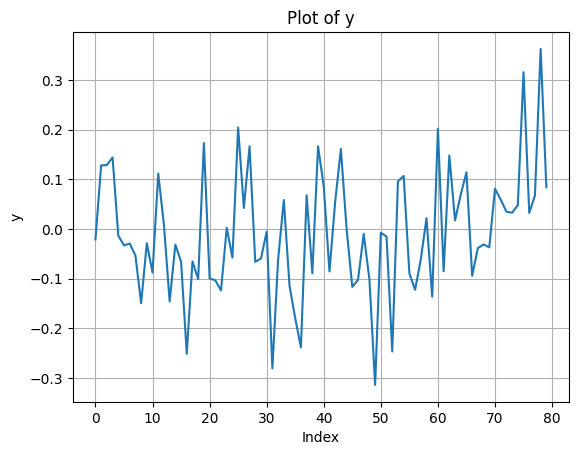

In [ ]:
import matplotlib.pyplot as plt
# Create x values based on the length of y

X = data[:, :-1]
y = data[:, -1]
x_plot = list(range(len(y)))  # Renamed the variable to avoid conflict with the range function

# Plot the values
plt.plot(x_plot, y)

plt.xlabel('Index')
plt.ylabel('y')
plt.title('Plot of y')
plt.grid(True)
plt.show()

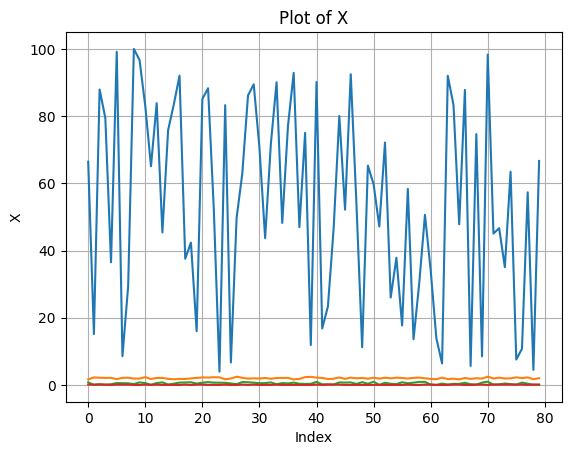

In [ ]:
import matplotlib.pyplot as plt
# Create x values based on the length of y


x_plot = list(range(len(X)))  # Renamed the variable to avoid conflict with the range function

# Plot the values
plt.plot(x_plot, (X))

plt.xlabel('Index')
plt.ylabel('X')
plt.title('Plot of X')
plt.grid(True)
plt.show()

In [ ]:
X = data[:, :-1]
y = data[:, -1]
product_xy = X[:, 0] *  X[:, 1] * X[:, 2] * X[:, 3]

# Reshape the product array to be a 2D column vector
product_xy = product_xy[:, np.newaxis]

# Concatenate the product column back to the original feature matrix
X = np.hstack((X, product_xy))

# Checking the new shape of X to confirm the addition of the new column
myalphas = np.logspace(-5, 6, 13)

models = LinearRegression, RidgeCV, LassoCV
model_names = 'linear regression', 'Ridge regression using CV', 'Lasso regression using CV'

minMax = MinMaxScaler()
X = minMax.fit_transform(X)
normaliser = Normalizer()
X= normaliser.fit_transform(X)

# X= scale(X)
# X = normalize(X)




basis_functions = [
    PolynomialFeatures(2, interaction_only=True, include_bias=False),
    PolynomialFeatures(3, interaction_only=True, include_bias=False),
    PolynomialFeatures(4, interaction_only=True, include_bias=False),
    PolynomialFeatures(5, interaction_only=True, include_bias=False),
    FunctionTransformer(np.sin, validate=True),
    FunctionTransformer(np.cos, validate=True),
    FunctionTransformer(np.exp, validate=True),
    FunctionTransformer(np.log1p, validate=True),
    SplineTransformer(degree = 3, n_knots =2, include_bias = False),
    RBFSampler(gamma=0.001, random_state=1),
    FunctionTransformer(piecewise_linear, validate=True)

    # FunctionTransformer(custom_transform, validate=True)


]

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for i, model in enumerate(models):
  print('Using regression of type: ', model_names[i])

  if model == LinearRegression:
    reg = model()


  elif model == RidgeCV:
    print('trying these parameter values ',myalphas)
    reg = model(alphas = myalphas)

  else:
    print('trying these parameter values ',myalphas)
    reg = model(alphas = myalphas, max_iter = 1000000)




  for function in basis_functions:
    pipeline = make_pipeline(function,reg)
    scores=[]
    for train, test in kf.split(X):

      X_train, X_test = X[train], X[test]
      y_train, y_test = y[train], y[test]
      # scores = cross_val_score(pipeline, X,y, cv=3, scoring = 'r2')

      pipeline.fit(X_train, y_train)

      y_pred = pipeline.predict(X_test)
      r2 = r2_score(y_test,y_pred)
      scores.append(r2)
      # x_plot = list(range(len(y_test)))
      # plt.plot(x_plot, y_test)
      # plt.plot(x_plot, y_pred)
      # plt.xlabel('Index')
      # plt.ylabel('y')
      # plt.title('Plot of y')
      # plt.grid(True)
      # plt.show()

    print( function)
    print(scores)
    print(np.mean(scores),"\n")






R^2 Score for fold: 0.05375401421924775


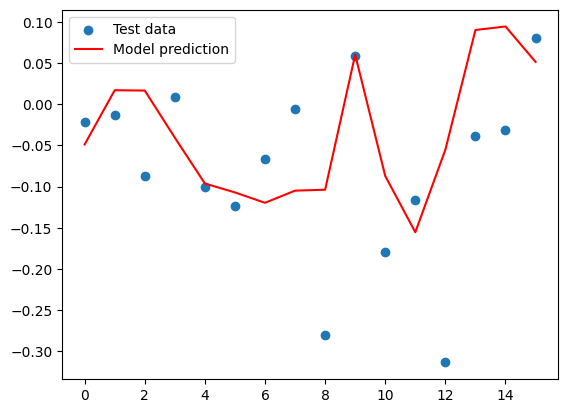

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


R^2 Score for fold: 0.27380054182931557


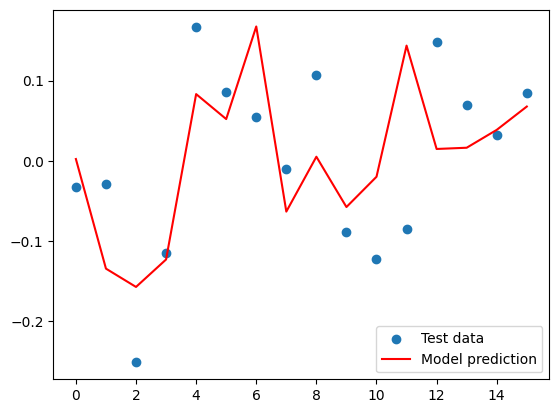

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


R^2 Score for fold: 0.23022640648652948


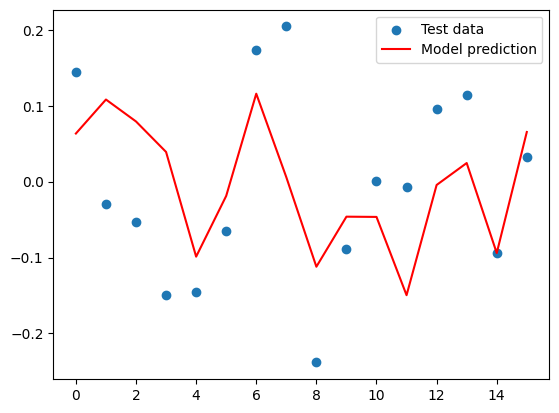

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


R^2 Score for fold: 0.4180807022240175


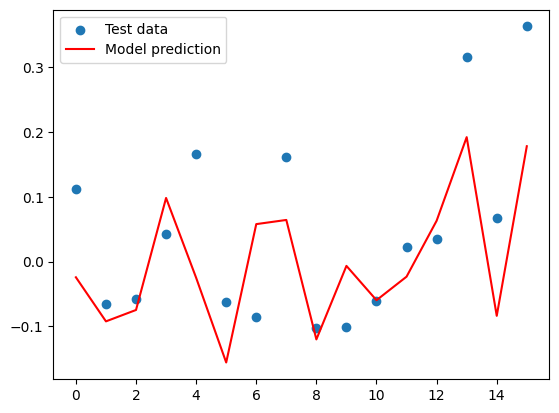

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


R^2 Score for fold: 0.44192854888212485


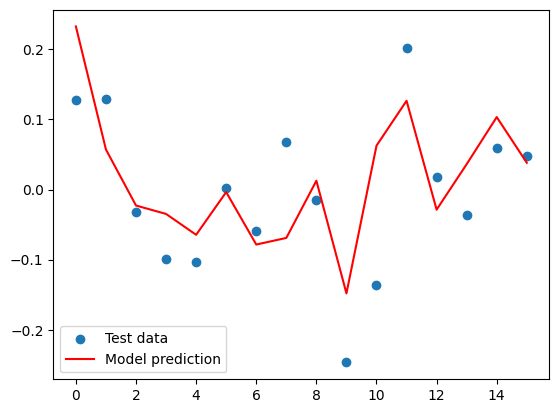

Mean R^2 Score: 0.28355804272824703


In [ ]:
def piecewise_linear(X, *params):
    num_features = X.shape[1]
    x0 = params[:num_features]
    y0 = params[num_features:2*num_features]
    k1 = params[2*num_features:3*num_features]
    k2 = params[3*num_features:4*num_features]

    result = np.zeros(X.shape[0])
    for i in range(num_features):
        result += np.piecewise(X[:, i], [X[:, i] < x0[i], X[:, i] >= x0[i]],
                               [lambda x, k1=k1[i], y0=y0[i]: k1*x + y0 - k1*x0[i],
                                lambda x, k2=k2[i], y0=y0[i]: k2*x + y0 - k2*x0[i]])
    return result

# Assuming 'data' is a numpy array or pandas DataFrame
# Here 'data' should be loaded or defined. For example:
# data = np.loadtxt('your_data_file.csv', delimiter=',')  # Load your data here

kf = KFold(n_splits=5, shuffle=True, random_state=42)
X = data[:, :-1]
y = data[:, -1]
scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Initial guess for parameters
    num_features = X_train.shape[1]
    initial_guess = [np.median(X_train[:, i]) for i in range(num_features)] + \
                    [np.mean(y_train)]*num_features + \
                    [0.1]*num_features + [0.1]*num_features

    # Fit the piecewise linear model
    p, e = optimize.curve_fit(piecewise_linear, X_train, y_train, p0=initial_guess)

    # Predict on the test set
    y_pred = piecewise_linear(X_test, *p)

    # Evaluate the model performance (e.g., R^2 score)
    r2 = r2_score(y_test, y_pred)
    scores.append(r2)
    print(f'R^2 Score for fold: {r2}')

    # Plot the results (optional)
    plt.scatter(range(len(y_test)), y_test, label='Test data')
    plt.plot(range(len(y_test)), y_pred, label='Model prediction', color='red')
    plt.legend()
    plt.show()

# Calculate and print the mean R^2 score
mean_r2 = np.mean(scores)
print(f'Mean R^2 Score: {mean_r2}')

In [ ]:
X = data[:, :-1]
y = data[:, -1]

myalphas = np.logspace(-5, 6, 13)

models = LinearRegression, RidgeCV, LassoCV
model_names = 'linear regression', 'Ridge regression using CV', 'Lasso regression using CV'

minMax = MinMaxScaler()
X_minMax = minMax.fit_transform(X)


normaliser = Normalizer()
X_normaliser= normaliser.fit_transform(X)


X_minMax_normal = normaliser.fit_transform(X_minMax)

datasets = [X_minMax,X_normaliser,X_minMax_normal]
datasets_names = 'min max dataset', 'normalised dataset', 'min max normal dataset',






basis_functions = [
    PolynomialFeatures(2, interaction_only=True, include_bias=False),
    PolynomialFeatures(3, interaction_only=True, include_bias=False),
    PolynomialFeatures(4, interaction_only=True, include_bias=False),
    FunctionTransformer(np.sin, validate=True),
    FunctionTransformer(np.cos, validate=True),
    FunctionTransformer(np.exp, validate=True),
    FunctionTransformer(np.log1p, validate=True),
    SplineTransformer(degree = 3, n_knots =2, include_bias = False),
    FunctionTransformer(piecewise_linear, validate=True)




]

best_r2=-9999
best_comb = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for i, model in enumerate(models):
  print('Using regression of type: ', model_names[i])

  if model == LinearRegression:
    reg = model()


  elif model == RidgeCV:
    print('trying these parameter values ',myalphas)
    reg = model(alphas = myalphas)

  else:
    print('trying these parameter values ',myalphas)
    reg = model(alphas = myalphas, max_iter = 1000000)

  for j,dataset in enumerate(datasets):
    print("using :" , datasets_names[j])

    for function in basis_functions:
      pipeline = make_pipeline(function,reg)
      scores=[]

      for train, test in kf.split(dataset):

        X_train, X_test = dataset[train], dataset[test]
        y_train, y_test = y[train], y[test]
        # scores = cross_val_score(pipeline, X,y, cv=3, scoring = 'r2')

        pipeline.fit(X_train, y_train)

        y_pred = pipeline.predict(X_test)
        r2 = r2_score(y_test,y_pred)
        scores.append(r2)
        # x_plot = list(range(len(y_test)))
        # plt.plot(x_plot, y_test)
        # plt.plot(x_plot, y_pred)
        # plt.xlabel('Index')
        # plt.ylabel('y')
        # plt.title('Plot of y')
        # plt.grid(True)
        # plt.show()

      print( function)
      print(scores)
      print(np.mean(scores),"\n")

      if (np.mean(scores) > best_r2):
        best_r2 = np.mean(scores)
        best_comb=[model_names[i],datasets_names[j],function,np.mean(scores)]


print("\n","the best combination is: ", best_comb  )










Maximum iteration reached


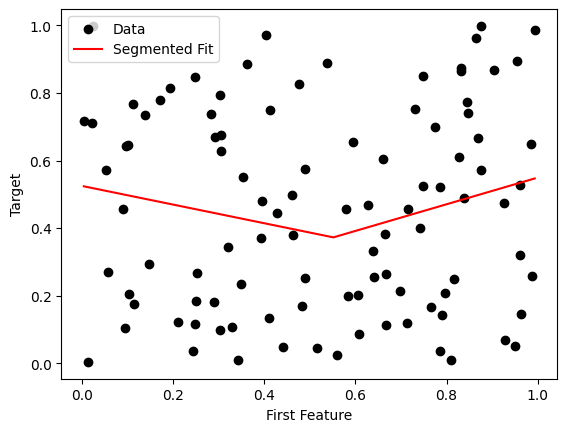

In [ ]:
import numpy as np
from numpy.linalg import lstsq
import matplotlib.pyplot as plt

# Define ramp and step functions
ramp = lambda u: np.maximum(u, 0)
step = lambda u: (u > 0).astype(float)

def SegmentedLinearRegMulti(X, Y, breakpoints):
    nIterationMax = 1000
    breakpoints = np.sort(np.array(breakpoints))
    dt = np.min(np.diff(X[:, 0]))  # Assume breakpoints are based on the first feature
    ones = np.ones((X.shape[0], 1))

    for i in range(nIterationMax):
        # Create the design matrix A
        Rk = [ramp(X[:, 0:1] - xk) for xk in breakpoints]
        Sk = [step(X[:, 0:1] - xk) for xk in breakpoints]
        A = np.hstack([ones, X] + Rk + Sk)

        # Linear regression: solve A*p = Y
        try:
            p = lstsq(A, Y, rcond=None)[0]
        except np.linalg.LinAlgError as e:
            print("LinAlgError:", e)
            return None, None

        # Parameters identification:
        a = p[0]
        b = p[1:1 + X.shape[1]]
        ck = p[1 + X.shape[1]:1 + X.shape[1] + len(breakpoints)]
        dk = p[1 + X.shape[1] + len(breakpoints):]

        # Estimation of the next breakpoints:
        with np.errstate(divide='ignore', invalid='ignore'):
            newBreakpoints = breakpoints - dk / np.where(ck != 0, ck, np.nan)

        # Handle potential NaN values
        newBreakpoints = np.where(np.isnan(newBreakpoints), breakpoints, newBreakpoints)

        # Stop condition
        if np.max(np.abs(newBreakpoints - breakpoints)) < dt / 5:
            break

        breakpoints = newBreakpoints
    else:
        print('Maximum iteration reached')

    # Compute the final segmented fit
    Xsolution_first_feature = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 500)
    Xsolution_other_features = np.mean(X[:, 1:], axis=0)
    Xsolution = np.column_stack([Xsolution_first_feature, np.tile(Xsolution_other_features, (500, 1))])

    ones_solution = np.ones(Xsolution.shape[0])
    Rk = [c * ramp(Xsolution[:, 0] - x0) for x0, c in zip(breakpoints, ck)]

    Ysolution = a * ones_solution + Xsolution.dot(b) + np.sum(Rk, axis=0)

    return Xsolution[:, 0], Ysolution

# Example data with 4 features
data = np.random.rand(100, 5)  # Random data for example
X = data[:, :-1]
y = data[:, -1]

# Initial breakpoints (based on the first feature)
initialBreakpoints = [0.3, 0.6]

# Plot the data
plt.scatter(X[:, 0], y, c='black', label='Data')

# Plot the segmented linear regression fit
result = SegmentedLinearRegMulti(X, y, initialBreakpoints)
if result[0] is not None and result[1] is not None:
    plt.plot(*result, '-r', label='Segmented Fit')

plt.xlabel('First Feature')
plt.ylabel('Target')
plt.legend()
plt.show()
